In [267]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 1e-3
batch_size = 128
num_epochs = 75

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Using device: cuda


In [268]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
    return dfs

def dataset_summary(df, show_counts=True):
    
    total_rows = len(df)
    total_duplicates = df.duplicated().sum()
    summary = pd.DataFrame({
        "dtype": df.dtypes,
        "non_null_count": df.notna().sum(),
        "missing_count": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique_count": df.nunique(),
        "duplicates_in_dataset": total_duplicates
    })
    print(f"Dataset shape: {df.shape}")
    if show_counts:
        print(f"Total rows: {total_rows}")
        print(f"Total duplicate rows: {total_duplicates}")
    summary = summary.sort_values(by="missing_%", ascending=False)
    return summary

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    print(f"Dropped target column: {feature_cols_to_drop}")
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_engi = df.copy()

    df_engi["TotalPastDue"] = (
        df_engi["NumberOfTime30-59DaysPastDueNotWorse"] +
        df_engi["NumberOfTimes90DaysLate"] +
        df_engi["NumberOfTime60-89DaysPastDueNotWorse"]
    )
    df_engi['HasDelinquencyBinary'] = (df_engi['TotalPastDue'] > 0).astype(int)
    df_engi['MajorDelinquencyBinary'] = (df_engi['NumberOfTimes90DaysLate'] > 0).astype(int)
    df_engi['HasMonthlyIncomeBinary'] = df_engi['MonthlyIncome'].notna().astype(int)
    df_engi['MonthlyDebtAmount'] = df_engi['DebtRatio'] * df_engi['MonthlyIncome']
    df_engi['AvailableCreditRatio'] = (
        df_engi['NumberOfOpenCreditLinesAndLoans'] /
        df_engi['NumberRealEstateLoansOrLines'].replace(0, np.nan)
    )
    df_engi['Log_MonthlyIncome'] = np.log1p(df_engi['MonthlyIncome'])
    df_engi['UtilToAgeRatio'] = df_engi['RevolvingUtilizationOfUnsecuredLines'] / df_engi['age']

    def credit_mix(row):
        if row['NumberRealEstateLoansOrLines'] == 0 and row['NumberOfOpenCreditLinesAndLoans'] == 0:
            return 'NoCredit'
        elif row['NumberRealEstateLoansOrLines'] > 0 and row['NumberOfOpenCreditLinesAndLoans'] == 0:
            return 'RealEstateOnly'
        elif row['NumberRealEstateLoansOrLines'] == 0 and row['NumberOfOpenCreditLinesAndLoans'] > 0:
            return 'OtherCreditOnly'
        else:
            return 'MixedCredit'

    df_engi['CreditMix'] = df_engi.apply(credit_mix, axis=1)

    threshold = 0.8
    df_engi['IsHighUtilizationBinary'] = (
        df_engi['RevolvingUtilizationOfUnsecuredLines'] > threshold
    ).astype(int)

    df_engi['DebtRatioPerAge'] = df_engi['DebtRatio'] / df_engi['age'].replace(0, np.nan)
    df_engi['MonthlyDebtPerIncome'] = df_engi['MonthlyDebtAmount'] / df_engi['MonthlyIncome'].replace(0, np.nan)
    df_engi['PastDuePerCreditLine'] = df_engi['TotalPastDue'] / (
        df_engi['NumberOfOpenCreditLinesAndLoans'] + df_engi['NumberRealEstateLoansOrLines']
    ).replace(0, np.nan)
    df_engi['UtilTimesDebtRatio'] = df_engi['RevolvingUtilizationOfUnsecuredLines'] * df_engi['DebtRatio']
    df_engi['AgeTimesIncome'] = df_engi['age'] * df_engi['MonthlyIncome']

    df_engi['age_capped'] = np.minimum(df_engi['age'], 100)
    df_engi['AgeBin'] = pd.cut(
        df_engi['age_capped'],
        bins=[0, 25, 35, 45, 55, 65, 75, 85, 100],
        labels=['Age_0_25', 'Age_25_35', 'Age_35_45', 'Age_45_55', 'Age_55_65', 'Age_65_75', 'Age_75_85', 'Age_85_100'],
        include_lowest=True
    )

    df_engi['DebtTimesUtil'] = df_engi['DebtRatio'] * df_engi['RevolvingUtilizationOfUnsecuredLines']
    df_engi['IncomePerOpenCredit'] = df_engi['MonthlyIncome'] / df_engi['NumberOfOpenCreditLinesAndLoans'].replace(0, np.nan)
    df_engi['PastDuePerAge'] = df_engi['TotalPastDue'] / df_engi['age'].replace(0, np.nan)
    df_engi['DebtPerCreditTimesAge'] = df_engi['DebtRatioPerAge'] * df_engi['NumberOfOpenCreditLinesAndLoans']

    print("Engineered features")
    return df_engi

def drop_high_missing_cols(df, threshold=0.3):
    
    missing_frac = df.isna().mean()
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped {len(hm_cols_to_drop)} columns with missing >{threshold*100:.0f}%")
        print(f"Columns dropped: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No columns dropped for missing threshold")
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    hc_cols_to_drop = [col for col in cat_cols if df[col].nunique() > threshold]
    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped {len(hc_cols_to_drop)} high-cardinality columns (> {threshold} unique)")
        print(f"Columns dropped: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high-cardinality columns dropped")
    return df_high, hc_cols_to_drop

def drop_correlated(df, threshold=0.95):
    
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes
    corr_matrix = df_temp.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    if corr_cols_to_drop:
        df_corr = df.drop(columns=corr_cols_to_drop)
        print(f"Dropped {len(corr_cols_to_drop)} highly correlated columns")
        print(f"Columns dropped: {corr_cols_to_drop}")
    else:
        df_corr = df.copy()
        print("No highly correlated features dropped")
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()
    return df_corr, corr_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    rare_maps = {}
    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True)
        rare_cats = freqs[freqs < threshold].index
        if len(rare_cats) > 0:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Collapsed {len(rare_cats)} rare categories in column '{col}'")
            print(f"Categories dropped: {list(rare_cats)}")
    if not rare_maps:
        print("No rare categories collapsed")
        rare_maps = None
    return df_copy, rare_maps

def impute_and_scale(df, threshold=1.0):
    
    df_copy = df.copy()
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    num_imputer = None
    cat_imputer = None
    robust_scaler = None
    std_scaler = None
    if numeric_cols:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[numeric_cols] = num_imputer.fit_transform(df_copy[numeric_cols])
    if cat_cols:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_cols] = cat_imputer.fit_transform(df_copy[cat_cols])
    if numeric_cols:
        skewness = pd.DataFrame(df_copy[numeric_cols]).skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols]).astype(np.float32)
        normal_cols = [c for c in numeric_cols if c not in skewed_cols]
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols]).astype(np.float32)
    df_processed = df_copy.copy()
    print("Imputed and scaled features")
    return df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler

def select_features_xgb(df, target, top_n=20, threshold=None, random_state=42):
 
    df_temp = df.copy()
    cat_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_temp[col] = df_temp[col].astype('category').cat.codes
    X_train, X_val, y_train, y_val = train_test_split(
        df_temp, target, test_size=0.2, random_state=random_state, stratify=target
    )
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    neg_count = sum(y_train == 0)
    pos_count = sum(y_train == 1)
    scale_pos_weight = neg_count / pos_count
    params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss", "auc"],
        "eta": 0.03,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 0.1,
        "lambda": 1.5,
        "alpha": 0.3,
        "seed": random_state,
        "scale_pos_weight": scale_pos_weight
    }
    evals = [(dtrain, "train"), (dval, "validation")]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )
    importance_dict = model.get_score(importance_type='gain')
    importances = pd.Series(importance_dict).sort_values(ascending=False)
    if threshold is None:
        threshold_value = importances.quantile(0.75)
        selected_features = importances[importances >= threshold_value].index.tolist()
    else:
        selected_features = importances[importances >= threshold].index.tolist()
    dropped_features = [col for col in df.columns if col not in selected_features]
    if selected_features:
        df_selected = df[selected_features].copy()
        print(f"Dropped {len(dropped_features)} features")
        print(f"Columns dropped: {dropped_features}")
    else:
        df_selected = df.copy()
        print("No features selected/dropped")
    top_features = importances.head(top_n)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features.index[::-1], top_features.values[::-1], color='skyblue')
    plt.xlabel("Feature Importance (gain)")
    plt.title(f"Top {top_n} XGBoost Feature Importances")
    plt.tight_layout()
    plt.show()
    return df_selected, selected_features

def transform_val_test(df, cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler):
    
    df_copy = df.copy()
    
    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')
    
    if rare_maps:
        for col, rare_cats in rare_maps.items():
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].apply(lambda x: x if x not in rare_cats else 'Other')
    
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    
    if numeric_cols and num_imputer:
        df_copy[numeric_cols] = df_copy[numeric_cols].replace([np.inf, -np.inf], np.nan)
        df_copy[numeric_cols] = num_imputer.transform(df_copy[numeric_cols])
    
    if robust_scaler:
        skewed_cols = robust_scaler.feature_names_in_
        df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols]).astype(np.float32)
    
    if std_scaler:
        normal_cols = [c for c in numeric_cols if robust_scaler is None or c not in robust_scaler.feature_names_in_]
        if normal_cols:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols]).astype(np.float32)
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    if cat_cols and cat_imputer:
        df_copy[cat_cols] = cat_imputer.transform(df_copy[cat_cols])
    
    if selected_features:
        df_copy = df_copy.reindex(columns=selected_features, fill_value=0)
    
    return df_copy

def check_and_drop_duplicates(df, target=None, drop_target_na=False, show_info=True):
    
    df_cleaned = df.copy()
    target_cleaned = None
    
    total_duplicates = df_cleaned.duplicated().sum()
    if total_duplicates > 0:
        df_cleaned = df_cleaned.drop_duplicates(keep='first')
        if show_info:
            print(f"Dropped {total_duplicates} duplicate rows. Remaining: {len(df_cleaned)}")
    
    if target is not None:
        target_cleaned = pd.Series(target).reindex(df_cleaned.index)
        if drop_target_na:
            mask = target_cleaned.notna()
            dropped = len(target_cleaned) - mask.sum()
            if dropped > 0 and show_info:
                print(f"Dropped {dropped} rows with missing target values")
            df_cleaned = df_cleaned.loc[mask].reset_index(drop=True)
            target_cleaned = target_cleaned.loc[mask].reset_index(drop=True)
        else:
            target_cleaned = target_cleaned.reset_index(drop=True)
        return df_cleaned, target_cleaned
    else:
        return df_cleaned

In [269]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [270]:
#summary
print(dataset_summary(df_train))
print(df_train.head(5))

Dataset shape: (150000, 11)
Total rows: 150000
Total duplicate rows: 609
                                        dtype  non_null_count  missing_count  \
MonthlyIncome                         float64          120269          29731   
NumberOfDependents                    float64          146076           3924   
SeriousDlqin2yrs                        int64          150000              0   
age                                     int64          150000              0   
RevolvingUtilizationOfUnsecuredLines  float64          150000              0   
DebtRatio                             float64          150000              0   
NumberOfTime30-59DaysPastDueNotWorse    int64          150000              0   
NumberOfOpenCreditLinesAndLoans         int64          150000              0   
NumberOfTimes90DaysLate                 int64          150000              0   
NumberRealEstateLoansOrLines            int64          150000              0   
NumberOfTime60-89DaysPastDueNotWorse    int64  

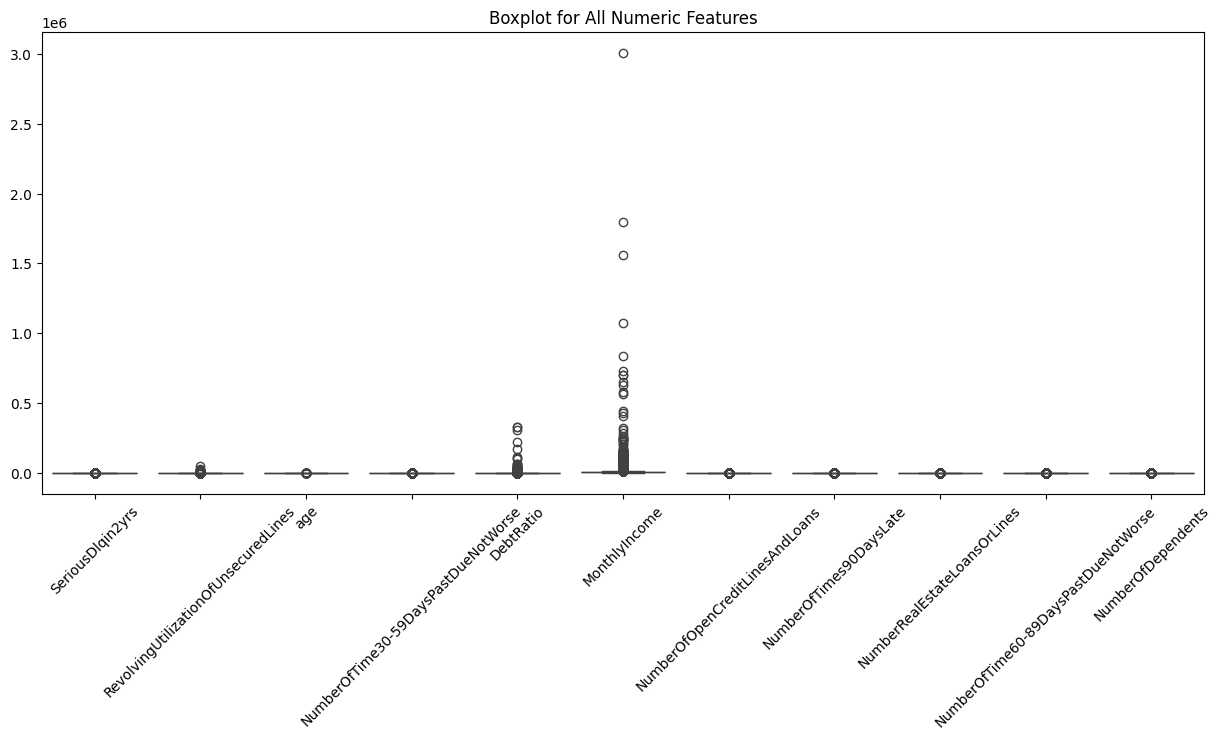

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64
count    149999.000000
mean         52.295555
std          14.771298
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64


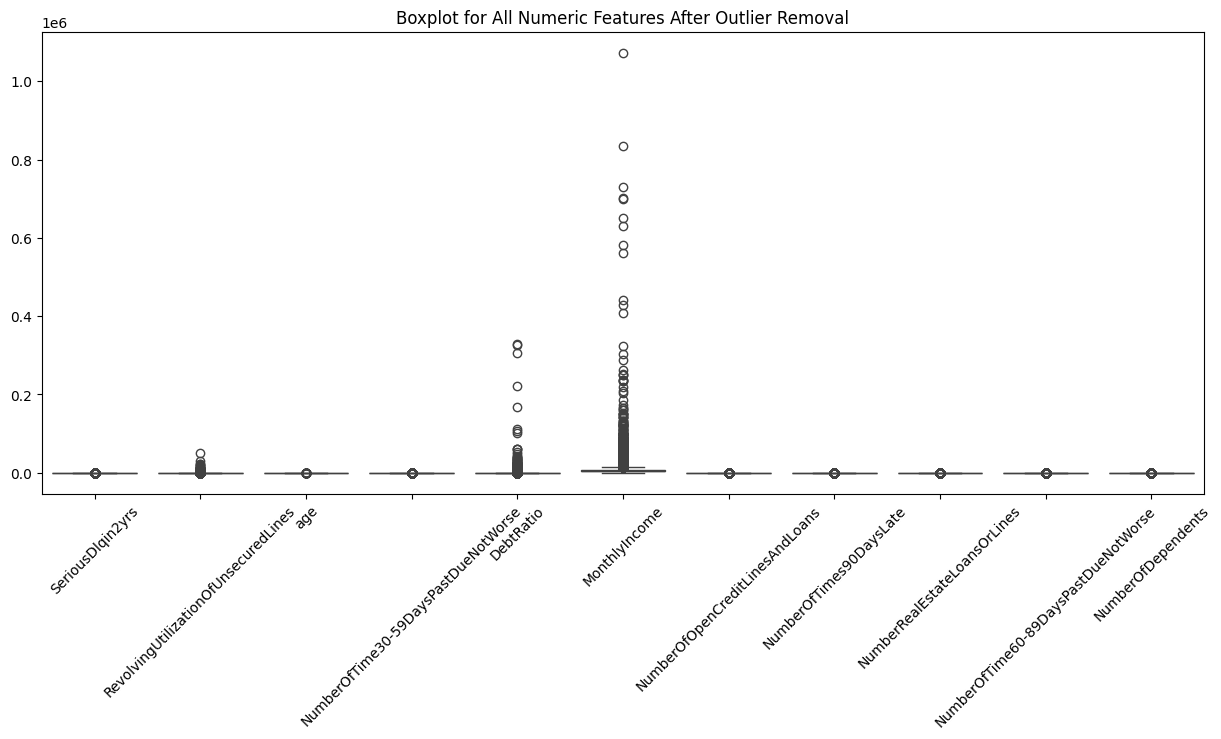

In [271]:
# Outlier Handling
numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features")
plt.xticks(rotation=45)
plt.show()

print(df_train['age'].describe())

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

print(df_train['age'].describe())

outliers_idx = df_train['MonthlyIncome'].nlargest(3).index
df_train = df_train.drop(index=outliers_idx)

numeric_df = df_train.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(15, 6))
sns.boxplot(data=numeric_df)
plt.title("Boxplot for All Numeric Features After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

In [272]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_train)
print(target.value_counts())

Dropped target column: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139970
1     10026
Name: count, dtype: int64


In [273]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

In [274]:
# Engineer_features
df_engi = engineer_features(X_train)

Engineered features


In [275]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_engi, threshold=1)

No columns dropped for missing threshold


In [276]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

No high-cardinality columns dropped


No highly correlated features dropped


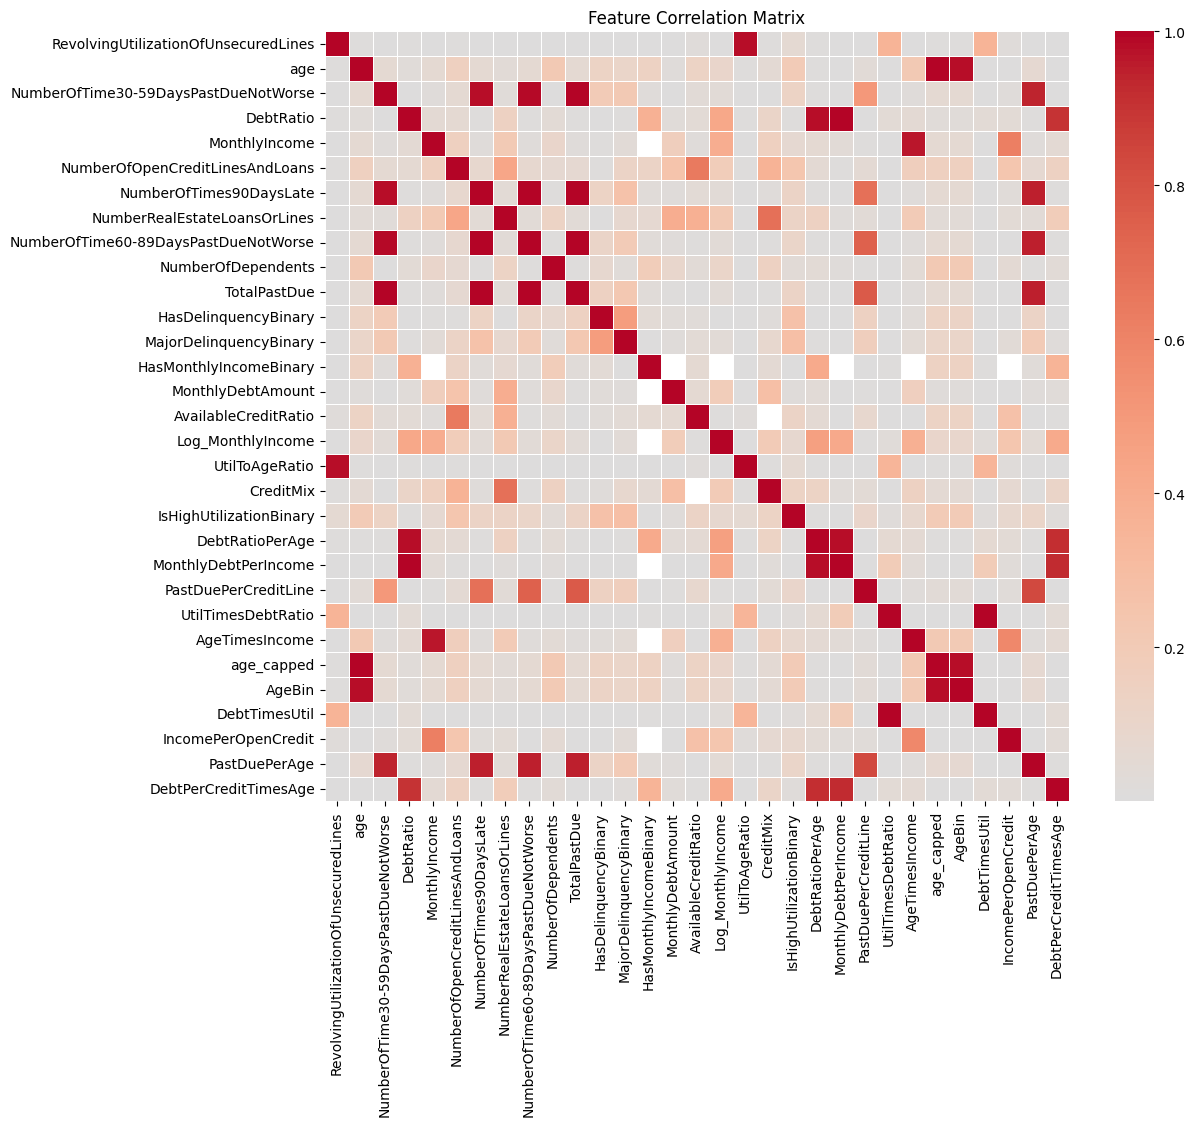

In [249]:
# Drop correlated features here
df_corr, corr_cols_to_drop = drop_correlated(df_high, threshold=9999)

In [250]:
# Collapse rare categories on training data
df_collapsed, rare_maps = collapse_rare_categories(df_corr, threshold=0.0125)

Collapsed 1 rare categories in column 'CreditMix'
Categories dropped: ['NoCredit']


In [251]:
# Impute and scale
df_processed, num_imputer, cat_imputer, robust_scaler, std_scaler  = impute_and_scale(df_collapsed , threshold=1.0)

Imputed and scaled features


Dropped 5 features
Columns dropped: ['DebtRatio', 'MonthlyIncome', 'NumberOfDependents', 'UtilTimesDebtRatio', 'DebtTimesUtil']


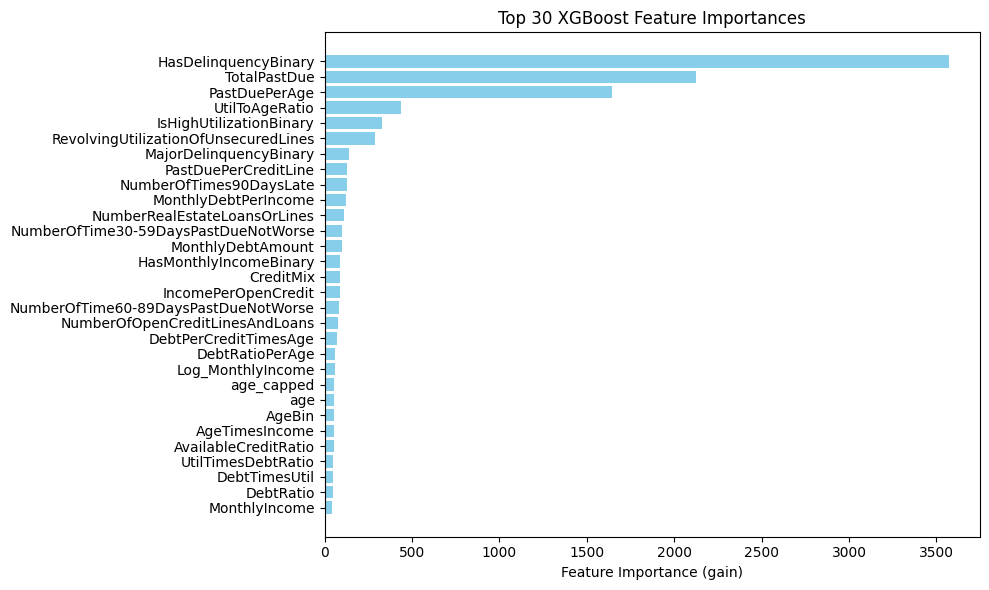

In [252]:
# feature selection
df_selected, selected_features = select_features_xgb(df_processed, y_train, threshold=50.2, top_n=30)

In [253]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + corr_cols_to_drop + hc_cols_to_drop

X_val = engineer_features(X_val)
X_val = transform_val_test(X_val, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)

X_test = engineer_features(X_test)
X_test = transform_val_test(X_test, all_cols_to_drop, selected_features, rare_maps, num_imputer, cat_imputer, robust_scaler, std_scaler)
X_train = df_selected.copy()

Engineered features with interactions
Engineered features with interactions


In [254]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped 451 duplicate rows. Remaining: 95545


In [255]:
#summary
print(dataset_summary(X_train))

Dataset shape: (95545, 26)
Total rows: 95545
Total duplicate rows: 0
                                        dtype  non_null_count  missing_count  \
HasDelinquencyBinary                  float32           95545              0   
TotalPastDue                          float32           95545              0   
PastDuePerAge                         float32           95545              0   
UtilToAgeRatio                        float32           95545              0   
IsHighUtilizationBinary               float32           95545              0   
RevolvingUtilizationOfUnsecuredLines  float32           95545              0   
MajorDelinquencyBinary                float32           95545              0   
PastDuePerCreditLine                  float32           95545              0   
NumberOfTimes90DaysLate               float32           95545              0   
MonthlyDebtPerIncome                  float32           95545              0   
NumberRealEstateLoansOrLines          float32      

In [256]:
# Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train)  
y_val = le.transform(y_val)       
y_test = le.transform(y_test)    

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=False)
X_val = pd.get_dummies(X_val, columns=cat_cols, drop_first=False)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=False)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("Train shape:", X_train.shape)
print("Val shape:  ", X_val.shape)
print("Test shape: ", X_test.shape)

missing_val_cols = set(X_train.columns) - set(X_val.columns)
missing_test_cols = set(X_train.columns) - set(X_test.columns)
print("Missing in val:", missing_val_cols)
print("Missing in test:", missing_test_cols)

print("NaNs in train:", X_train.isna().sum().sum())
print("NaNs in val:", X_val.isna().sum().sum())
print("NaNs in test:", X_test.isna().sum().sum())

Train shape: (95545, 35)
Val shape:   (24000, 35)
Test shape:  (30000, 35)
Missing in val: set()
Missing in test: set()
NaNs in train: 0
NaNs in val: 0
NaNs in test: 0


In [257]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)
print("Class weights:", class_weight_dict)

Class weights: {np.int64(0): np.float64(0.5358004060071108), np.int64(1): np.float64(7.483161027568922)}


In [258]:
# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 95545, Val: 24000, Test: 30000


In [259]:
# Model
class NN(nn.Module):
    def __init__(self, num_input):
        super().__init__()
        self.fc1 = nn.Linear(num_input, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.out = nn.Linear(128, 1)
        self.act = nn.ReLU()
        self.drop = nn.Dropout(0.3)

    def forward(self, x):
        x = self.act(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.act(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.out(x)         
        return x.squeeze(1)

num_input = X_train.shape[1]  
model = NN(num_input).to(device)

print(model)
sum(p.numel() for p in model.parameters())

NN(
  (fc1): Linear(in_features=35, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
)


43009

In [260]:
# Loss
class WeightedBinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets, weights=None):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if weights is not None:
            focal_loss = focal_loss * weights  
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = WeightedBinaryFocalLoss(alpha=alpha, gamma=3)

In [261]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
weights_tensor = weights_tensor.to(device)

best_model_state = None
best_auc = 0.0
patience_counter = 0
patience = 17 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_logits = []
    train_labels = []

    for Xb, yb in train_loader:
        Xb = Xb.to(device)
        yb = yb.to(device).float()

        optimizer.zero_grad()
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * Xb.size(0)

        train_logits.append(logits.detach().cpu())
        train_labels.append(yb.cpu())

    train_loss = running_loss / len(train_loader.dataset)
    train_logits = torch.cat(train_logits)
    train_labels = torch.cat(train_labels)
    train_probs = torch.sigmoid(train_logits).numpy()
    train_auc = roc_auc_score(train_labels.numpy(), train_probs)

    model.eval()
    val_loss_running = 0.0
    val_logits = []
    val_labels = []

    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(device)
            yb = yb.to(device).float()

            logits = model(Xb)
            loss = loss_fn(logits, yb)
            val_loss_running += loss.item() * Xb.size(0)

            val_logits.append(logits.cpu())
            val_labels.append(yb.cpu())

    val_loss = val_loss_running / len(val_loader.dataset)
    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits).numpy()
    val_auc = roc_auc_score(val_labels.numpy(), val_probs)

    if val_auc > best_auc:
        best_auc = val_auc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    scheduler.step(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | "
          f"Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

model.load_state_dict(best_model_state)
print(f"Best model (val_auc={best_auc:.4f}) restored")

Epoch 1/75 | Train loss: 0.034796 | Train AUC: 0.6669 | Val loss: 0.030617 | Val AUC: 0.8079
Epoch 2/75 | Train loss: 0.029300 | Train AUC: 0.7596 | Val loss: 0.029362 | Val AUC: 0.8302
Epoch 3/75 | Train loss: 0.028199 | Train AUC: 0.7825 | Val loss: 0.029456 | Val AUC: 0.8313
Epoch 4/75 | Train loss: 0.027461 | Train AUC: 0.8004 | Val loss: 0.029897 | Val AUC: 0.8319
Epoch 5/75 | Train loss: 0.027249 | Train AUC: 0.8039 | Val loss: 0.028208 | Val AUC: 0.8437
Epoch 6/75 | Train loss: 0.027089 | Train AUC: 0.8047 | Val loss: 0.028616 | Val AUC: 0.8451
Epoch 7/75 | Train loss: 0.026923 | Train AUC: 0.8086 | Val loss: 0.029299 | Val AUC: 0.8137
Epoch 8/75 | Train loss: 0.026727 | Train AUC: 0.8131 | Val loss: 0.029360 | Val AUC: 0.8523
Epoch 9/75 | Train loss: 0.026594 | Train AUC: 0.8162 | Val loss: 0.029435 | Val AUC: 0.8317
Epoch 10/75 | Train loss: 0.026381 | Train AUC: 0.8196 | Val loss: 0.029882 | Val AUC: 0.8379
Epoch 11/75 | Train loss: 0.026297 | Train AUC: 0.8221 | Val loss: 0.

Best threshold for F1: 0.35314402
              precision    recall  f1-score   support

      Repaid       0.97      0.88      0.93     27995
   Defaulted       0.28      0.64      0.40      2005

    accuracy                           0.87     30000
   macro avg       0.63      0.76      0.66     30000
weighted avg       0.93      0.87      0.89     30000

Accuracy: 86.81%
ROC AUC: 0.857
TP=1292, FP=3244, TN=24751, FN=713
Accuracy for class 'Repaid': 88.41%
Accuracy for class 'Defaulted': 64.44%


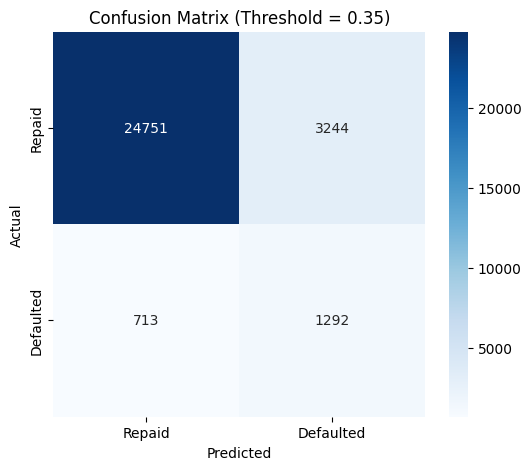

In [262]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)  
        y_val_probs.extend(probs.cpu().numpy())
    
y_val_probs = np.array(y_val_probs)

# Target defaults
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
f_beta_scores = [fbeta_score(y_val, (y_val_probs > t).astype(int), beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f_beta_scores)]

y_test_probs = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())
y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()

In [263]:
# Data sets
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test) 

In [264]:
# Model
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"], 
    "eta": 0.03,
    "max_depth": 4,
    "min_child_weight": 1, 
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0.1,             
    "lambda": 1.5, 
    "alpha": 0.3, 
    "seed": 42,
    "scale_pos_weight": scale_pos_weight
}

evals = [(dtrain, "train"), (dval, "validation")]

scale_pos_weight: 13.966322055137844


In [265]:
# Train
model_b = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-logloss:0.68194	train-auc:0.84947	validation-logloss:0.68175	validation-auc:0.85993
[50]	train-logloss:0.48236	train-auc:0.86241	validation-logloss:0.47838	validation-auc:0.87245
[100]	train-logloss:0.45753	train-auc:0.86614	validation-logloss:0.45417	validation-auc:0.87422
[150]	train-logloss:0.44912	train-auc:0.86934	validation-logloss:0.44699	validation-auc:0.87530
[200]	train-logloss:0.44526	train-auc:0.87241	validation-logloss:0.44424	validation-auc:0.87571
[250]	train-logloss:0.44189	train-auc:0.87528	validation-logloss:0.44187	validation-auc:0.87565
[254]	train-logloss:0.44154	train-auc:0.87550	validation-logloss:0.44157	validation-auc:0.87571


Best threshold for F1: 0.64793575
              precision    recall  f1-score   support

      Repaid       0.97      0.90      0.93     27995
   Defaulted       0.32      0.65      0.43      2005

    accuracy                           0.88     30000
   macro avg       0.65      0.78      0.68     30000
weighted avg       0.93      0.88      0.90     30000

Accuracy: 88.31%
ROC AUC: 0.871
TP=1312, FP=2815, TN=25180, FN=693
Accuracy for class 'Repaid': 89.94%
Accuracy for class 'Defaulted': 65.44%


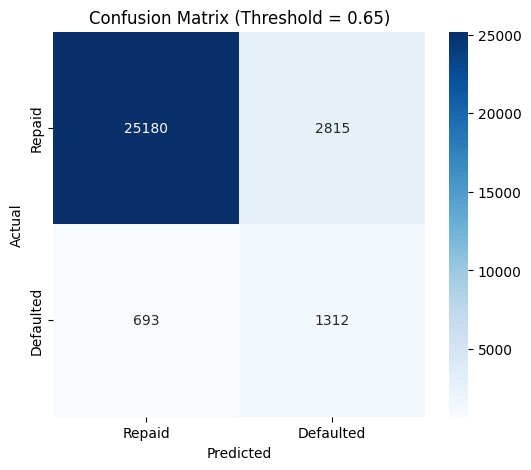

In [266]:
# Evaluation
y_probs = model_b.predict(dtest) 

# Target defaults
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
f_beta_scores = [fbeta_score(y_test, (y_probs > t).astype(int), beta=2) for t in thresholds]
best_thresh = thresholds[np.argmax(f_beta_scores)]

y_pred = (y_probs > best_thresh).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold for F1:", best_thresh)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh:.2f})")
plt.show()
